<div align='center'>
<h2>
Lab 5 - Detekcja emocji w interfejsach człowiek komputer

<h4> Antoni Pawłowicz 191733

## _Zadanie 1_
Na dowolnym obrazie przedstawiającym pojedynczą twarz zaznacz
wszystkie odnalezione punkty charakterystyczne.

Na obrazie mężczyzny pokazujemy punktu charaketrystyczne twarzy. Dla każdego punktu charakterystyczengo twarzy (landmark) rysujemy niebieską kropkę.
```
for face in faces:
        landmarks=predictor(img, face)
        for i in range(68):
            x = landmarks.part(i).x
            y = landmarks.part(i).y
            cv2.circle(img, (x,y), 2, (255,0,0), 1)
```
kod:

In [1]:
import cv2
import dlib
import matplotlib.pyplot as plt

p = "shape_predictor_68_face_landmarks.dat"

def show_landmarks(path):
    img= cv2.imread(path)
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Inicjalizacja detektora
    detector = dlib.get_frontal_face_detector()
    # Detekcja
    faces = detector(gray)
    # Inicjalizacja predyktora keypointow
    predictor = dlib.shape_predictor(p)

    for face in faces:
        landmarks=predictor(img, face)
        for i in range(68):
            x = landmarks.part(i).x
            y = landmarks.part(i).y
            cv2.circle(img, (x,y), 2, (255,0,0), 1)
                
        x1=face.left()
        y1=face.top()
        x2=face.right()
        y2=face.bottom()
        cv2.rectangle(img, (x1,y1), (x2,y2),(0,0,255),5)

    cv2.imshow("Face lanndmarks",img)
    k = cv2.waitKey(0)
    if k==27:  # escap
        cv2.destroyAllWindows()

    #plt.imshow(img)

#show_landmarks('face.jpg')

In [2]:
from IPython.display import Image

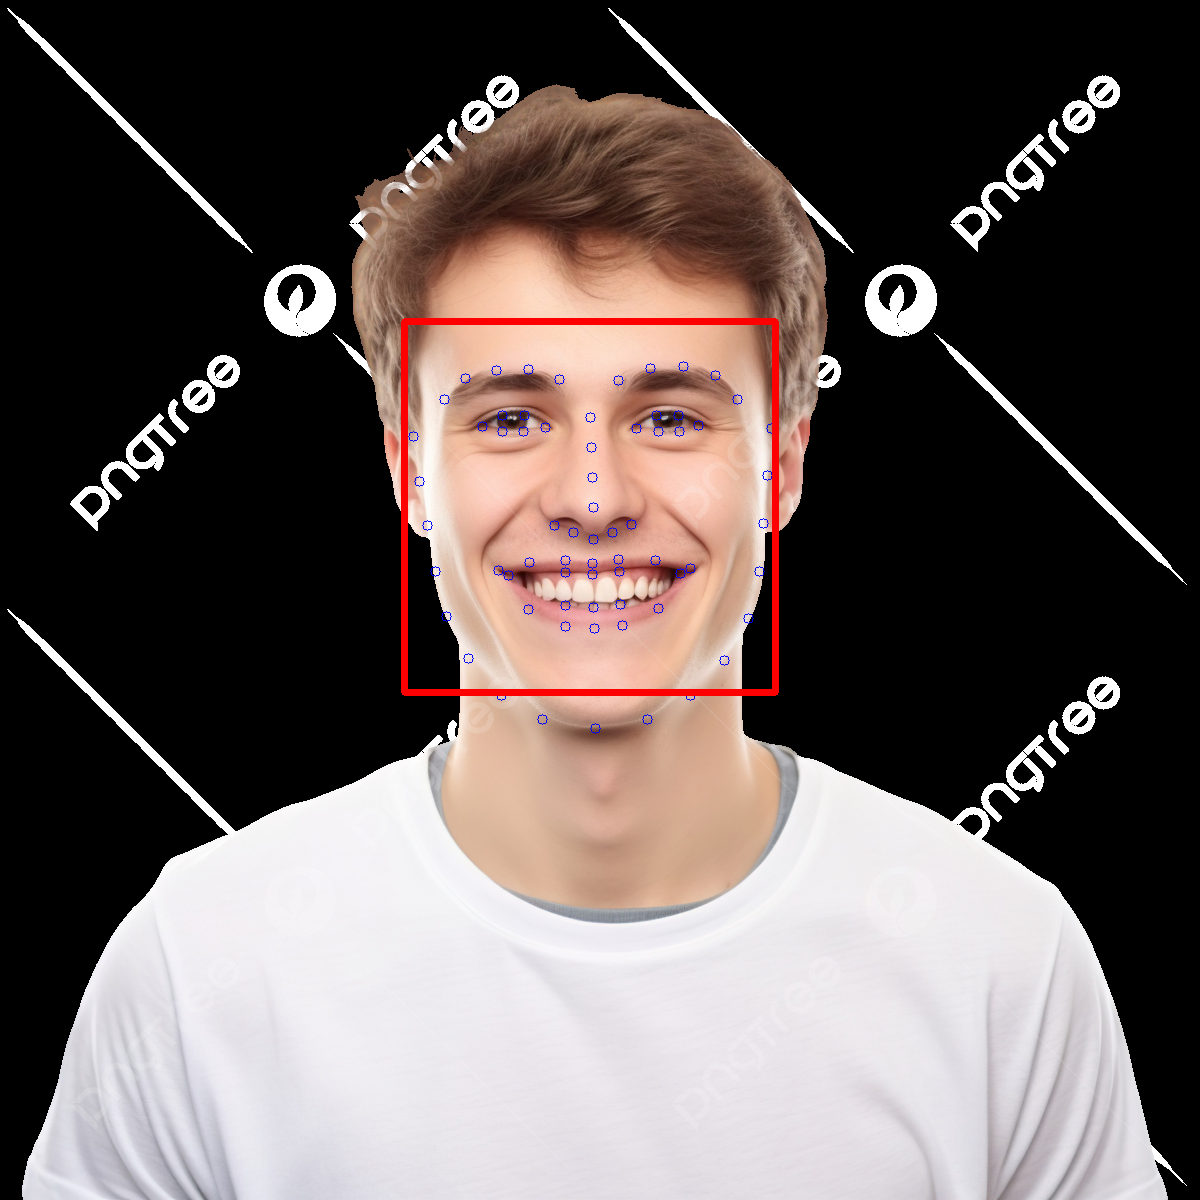

In [3]:
Image('./face_lands.png')

## _Zadanie 2_
Na dowolnym obrazie przedstawiającym więcej niż jedną twarz zaznacz
wszystkie odnalezione punkty charakterystyczne.

Identyczna funkcja używana jest dla grupy ludzi

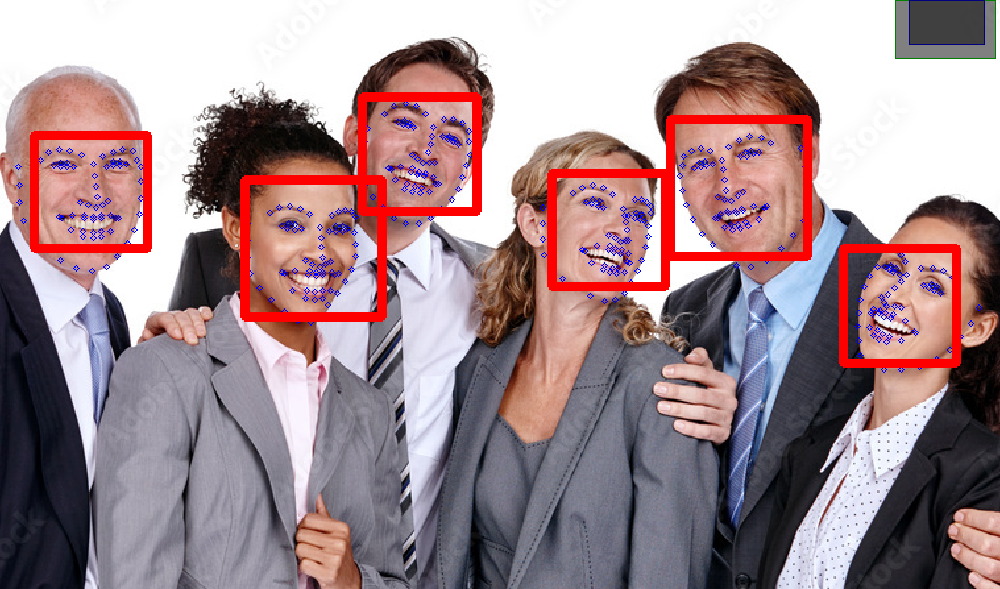

In [4]:
Image('./people_smiling.png')

## _Zadanie 3_
Wytrenuj klasyfikator kNN do detekcji określonej emocji. W tym celu:

a) wybierz wektor parametrów (cech) istotnych w detekcji określonej emocji (oprócz
samego położenia punktów mogą to być parametry pośrednie obliczone na podstawie
tych punktów – odległości, kąty itp.),

b) stwórz zbiór treningowy obrazów dla dwóch klas (emocja, brak emocji), a następnie
wyznacz z niego (automatycznie) wektory parametrów (wektor wejściowy
klasyfikatora),

c) dobierz parametry klasyfikatora kNN i wykonaj predykcję na obrazie innym niż ze
zbioru treningowego.

Dane używane do tego zadania pochodzą z: https://www.kaggle.com/datasets/chazzer/smiling-or-not-face-data?resource=download

Dane te zawierają w 2 folderach zdjęcia uśmiechniętych i nie uśmiechniętych osób.

Przykładywe dane:

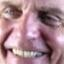

In [5]:
Image('./archive/smile/James_Jones_0001.jpg')

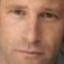

In [6]:
Image('./archive/non_smile/Aaron_Eckhart_0001.jpg')

Dla każdej twarzy ze zbioru podaj koordynaty punktów charakterystycznych
(Jest to rozwiązanie raczej suboptymalne z perspektywy time complexity - ale działa :) ). Koordynaty te centrowane są względem środku twarzy.

```
smiling = os.listdir('./archive/smile')
not_smiling = os.listdir('./archive/non_smile')

p = "shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(p)


def get_relative_landmarks(path):
    try:
        img= cv2.imread(path)
        gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        detector = dlib.get_frontal_face_detector()
        faces = detector(gray)
        lands=[]
    
        x1=faces[0].left()
        y1=faces[0].top()
        x2=faces[0].right()
        y2=faces[0].bottom()
        face_x_center = (x1+x2)/2
        face_y_center = (y1+y2)/2

        landmarks=predictor(img, faces[0])
        for i in range(68):
            x = landmarks.part(i).x
            y = landmarks.part(i).y
            x -= face_x_center #center x
            y -= face_y_center #center y

            lands.append((x,y))

        lands = np.array(lands).reshape(-1)
    except:
        lands = None
    return lands

smiling_data=[]

for path in smiling:
    a = get_relative_landmarks(os.path.join('./archive/smile', path))
    if a is not None:
        smiling_data.append(a)

non_smiling_data=[]

for path in not_smiling:
    a = get_relative_landmarks(os.path.join('./archive/non_smile', path))
    if a is not None:
        non_smiling_data.append(a)
```

Złącz dane i dodaj label'e

```
smiling_data = np.vstack(smiling_data)
non_smiling_data = np.vstack(non_smiling_data)

print(smiling_data.shape, non_smiling_data.shape) # (48, 136) (54, 136)

x = np.vstack((smiling_data, non_smiling_data))
y = np.concatenate((np.ones((smiling_data.shape[0])), np.zeros((non_smiling_data.shape[0]))))

print(x.shape, y.shape) # (102, 136) (102,)
```

W celu przyśpiesznie czasu processing'u danych, ręcznie zmniejszyłem ilość zdjęć i obydwie klasy Smile | non_smile są reprezentatywne (48 i 54 danych)

W celu ułatwienia procesu wybrania odpowiednich cech skorzystałem z _selector'a_

```
selector = SelectFromModel(estimator=GradientBoostingClassifier(), max_features=64).fit(x, y)

transformed_data = selector.transform(x)

print(transformed_data.shape) # (102, 13)

```

Selector ten wybrał 13 istotnych danych (z wiadomych tylko dla siebie powodów). Jest to rozwiązanie tzw. leniwe gdyż nie wiemy dlaczego i konkretnie jakie dane zostały wybrane, ale w przypadku gdy nie jestem pewny czy jest konkretny landmark to uważam że jes to rozwiąznie nie-najgorsze.

trenujemy nasz model

```
transformed_data, x_test, y_train, y_test = train_test_split(transformed_data, y.reshape(-1,1))


model = KNeighborsClassifier(n_neighbors=3)
model.fit(transformed_data,y_train)

test_ = model.predict(x_test)
acc = accuracy_score(test_, y_test)

print(f'train_acc: {acc:.2f}')

test_sample = '/home/administrator3/Downloads/lab7(1)/archive/test/Alan_Ball_0002.jpg'

test_data = get_relative_landmarks(test_sample).reshape(1,-1)
test_data = selector.transform(test_data)

pred = model.predict(test_data)

print(f'prediction: {pred}')
```

Model accuracy on test set: 1.00 (seems suspicious but ok)
The model has predicted the test photo to be smiling (1)

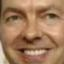

In [7]:
# test image
Image('/home/administrator3/Downloads/lab7(1)/archive/test/Alan_Ball_0002.jpg')